1. Make sure you fill in all cells contain `YOUR CODE HERE` or `YOUR ANSWER HERE`.
2. After you finished, `Restart the kernel & run` all cell in order.

# Project I: Basics of Neural Network
## Deadline: Oct 14, 11:59 pm

You have learned about the basics of neural network training and testing during the class. Now let's gain hands-on experience on how to implement them! We adopt the image classification task as a proxy to check how good your model is. Concretely, this project is split into two parts:

- **Part I: play with feed-forward neural network**
    - Build your feed-forward network with different layers and activation functions
    - Define the gradient descent function to update the parameters
    - Adjust the learning rate to achieve better performance 
    - Run the evaluation function


- **Part II: implement your own Convolutional Neural Network**
    - Train the CNN and compare it with the feed-forward neural network


Let's get started!

## 1. Package

Let's first import all the packages that you will need.

- **torch, torch.nn, torch.nn.functional** are the fundamental modules in pytorch library, supporting Python programs that facilitates building deep learning projects.
- **torchvision** is a library for Computer Vision that goes hand in hand with PyTorch
- **numpy** is the fundamental package for scientific computing with Python programs.
- **matplotlib** is a library to plot graphs and images in Python.
- **math, random** are the standard modules in Python.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from project1_utils import *

print("Import packages successfully!")

Import packages successfully!


A helper function is provided:

```python
def set_seed(seed):
    """
    Use random seed to ensure that results are reproducible.
    """
```

In [2]:
seed = 1
set_seed(seed)

## 2. Dataset

You will use the "cat vs. dog" dataset for this assignment.

Let's load the dataset first using pytorch dataset and loader modules.

In [3]:
# the number of images in a batch
batch_size = 32

# load dataset
trainset = dataset(path='/u/cs298/Fall2022/project1/dataset/trainset.h5')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = dataset(path='/u/cs298/Fall2022/project1/dataset/testset.h5')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# name of classes
classes = ('cat', 'dog')

print ("Number of training examples: " + str(trainset.length))
print ("Number of testing examples: " + str(testset.length))

Number of training examples: 10000
Number of testing examples: 2000


Let's visualize some examples in the dataset, the tool to show images is provided as below:

```python
def imshow(images):
    """
    Display the input images in a plot
    """
```

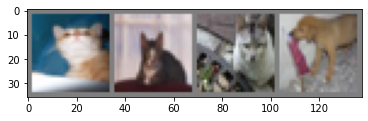

  cat   cat   cat   dog


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

num_toshow = 4

# show images
imshow(torchvision.utils.make_grid(images[:num_toshow]))

# print labels
_, indexs = torch.max(labels, 1) 
print(' '.join('%5s' % classes[indexs[j]] for j in range(num_toshow)))

# Part I

---

## 3. Build your feedforward neural network.

In this cell, you will be required to build a **three-layer multilayer perceptron (MLP)** to classify images into different categories. 

<!-- As we know from the class, **each layer** of a MLP can be denoted as the following mathematical operation:

$$z = W^T x + b$$ $$a = \sigma(z)$$

Here, $W, b$ denote the weights and biases, and $a, \sigma$ denote activation output and activation function, respectively.
**The function is parameterized by $W, b$ as well as the choice of $\sigma(\cdot)$**.

Note that it is valid for $\sigma(\cdot)$ to be the identity function, or $z = \sigma(z)$.

----

**Question 1 (6 points):** Now, let's implement functions at the layer level to do the following:

Hint: To implement $W^Tx+b$ in PyTorch, one way is to write it as `x.mm(W) + b`. -->

The size of input images is a batch-like tensor $ X \in \mathbb{R}^{B \times C \times H \times W}$, where $B$ denotes the batch size. Vectorize the image pixels equals to transforming into a vector $X_{vector} \in \mathbb{R}^{B \times CHW}$.

**Question 1 (4 points):** To process image data with feed-forward neural network, the image pixels should be vectorized. So first, implement a vectorized function (refer to lecture "feedforward network"). 

In [5]:
def image_vectorization(image_batch):
    """
    Input: 
        image_batch: a batch of images with shape [b, c, h, w]
    Output: 
        vectorized_image_batch: a batch of neurons
    """
    
    # vectorize the image pixels
    vectorized_image_batch = []
    for image in image_batch:
        vectorized_image_batch.append(torch.flatten(image))
    
    return torch.stack(vectorized_image_batch)
    

As we know from the class, **each layer** of a MLP can be denoted as the following mathematical operation:

$$z = W^T x + b$$ 

Here, $W, b$ denote the weights and biases. The function is **parameterized by $W, b$**.

**Question 2 (4 points):** Given the desired input, output dimensions, generate the parameters $W, b$. 

In [6]:
def get_layer_params(input_dim: int, output_dim: int):
    """
    Input: 
        input_dim: number of neurons in the input
        output_dim: number of neurons produced by the layer
    Output: 
        a dictionary of generated parameters
            - w: weights
            - b: biases
    """
    
    # generate the parameters
    w = torch.randn(input_dim, output_dim, requires_grad = True)
    b = torch.randn(output_dim, requires_grad = True)
    
    return {'w': w,
            'b': b}
    

Following with the previous linear layer, an activation layer is required to add non-linearity to the network:

 $$a = \sigma(z)$$

 $a, \sigma$ denote activation output and activation function, respectively.
The entire layer function is also **parameterized by choice of $\sigma(\cdot)$**.

**Question 3 (4 points):** You need an activation wrapper function to support the following three activation functions (details are in the lecture slide).
- Sigmoid
- tanh
- ReLU

Note: don't directly call `torch.Sigmoid` and etc. Your implementation should follow their mathematical equation.

In [7]:
def activation_wrapper(x, activation='relu'):
    """
    Input: 
        x: the input neuron values
        activation: name of activation, could be one in ['relu', 'sigmoid', 'tanh']
    Output: 
        a: the corresponding activated output
    """

    if activation == 'relu':
        for neuron in x:
            idxs = neuron < 0
            neuron[idxs] = 0
        a = x
    elif activation == 'sigmoid':
        a = 1 / (1 + torch.exp(-x))
    elif activation == 'tanh':
        a = (torch.exp(-x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
 
    return a
    

**Question 4 (4 points):** Given the layer parameters $W, b$ and the choice of $\sigma(\cdot)$, compute the output for an MLP layer with input $x$. 

Hint:  `tensor.mm()` can be useful.

In [8]:
def layer_forward_computation(x, params, activation):
    """
    Input: 
        x: the input to the layer
        params: parameters of each layer
        activation: activation type
    Output: 
        a: the output after the activation
    """
    
    # compute the output for layer
    layer_output = torch.mm(x, params['w']) + params['b']
    a = activation_wrapper(layer_output, activation)
    
    return a

---

Back to building our three-layer MLP for classification. If you have implemented the functions above correctly,
now the processing of putting everything together will be very easy.

Just like other parts of your programming experience,
knowing how to efficiently abstract and modularize components of your program will be critical in deep learning.

**Architecture Requirement**:

We now describe in details how our three-layer MLP should be built in PyTorch.

1. In the dataset, the size of input image is a tensor $ X \in \mathbb{R}^{B \times 3 \times 32 \times 32}$, where $B$ denotes the batch size.
2. Vectorize the image pixels to a vector $X_{vector} \in \mathbb{R}^{B \times 3072}$.
3. We now begin describing the specific architecture of the model, although this is not the only design choice, and feel free to change the hidden dimensions of the parameters
4. Layer1: set your parameters so the input is projected from $\mathbb{R}^{B \times 3072}$ to $\mathbb{R}^{B \times 256}$, use ReLU as your activation function
5. Layer2: set your parameters so the input is projected from $\mathbb{R}^{B \times 256}$ to $\mathbb{R}^{B \times 128}$, use ReLU as your activation function
6. Layer3: set your parameters so the input is projected from $\mathbb{R}^{B \times 128}$ to $\mathbb{R}^{B \times 2}$, use sigmoid function as your activation function

---

**Question 5 (4 points):** Let's build the three-layer MLP using the functions you have defined.

In [9]:
layer1_params: dict = dict()
layer2_params: dict = dict()
layer3_params: dict = dict()

def net(X, params, activations):
    """
    Input: 
        X: the input images to the network
        params: a dictionary of parameters(W and b) for the three different layers
        activations: a dictionary of activation function names for the three different layers
    Output: 
        output: the final output from the third layer
    """
    
    # build your network forward
    output = image_vectorization(X)

    for layer in params.keys():
        output = layer_forward_computation(output, params[layer], activations[layer])

    return output

**Question 6 (4 points):** All the required functions are defined right now. It's time to create your actual parameters and activation functions for the network.

In [10]:
""" We prepare serval dictories to store the parameters and activations for different   """
layer1_params: dict = dict()
layer2_params: dict = dict()
layer3_params: dict = dict()
params: dict = dict()
activations: dict = dict()
    
# TODO: define your layer parameters and activations here. For example, layer1_params = ? 
# and pack your parameters with layer name, e.g., params['layer1'] = layer1_params

layer1_params['input_dim'] = 3072
layer1_params['output_dim'] = 256
layer1_params.update(get_layer_params(layer1_params['input_dim'], layer1_params['output_dim']))

layer2_params['input_dim'] = 256
layer2_params['output_dim'] = 128
layer2_params.update(get_layer_params(layer2_params['input_dim'], layer2_params['output_dim']))

layer3_params['input_dim'] = 128
layer3_params['output_dim'] = 2
layer3_params.update(get_layer_params(layer3_params['input_dim'], layer3_params['output_dim']))

params['layer1'] = layer1_params
params['layer2'] = layer2_params
params['layer3'] = layer3_params

activations['layer1'] = 'relu'
activations['layer2'] = 'relu'
activations['layer3'] = 'sigmoid'

## 4. Backpropagation and optimization

After finishing the forward pass, you now need to compute gradients for all Tensors with `requires_grad=True`, e.g., parameters of layer1. These gradients will be used to update parameters via gradient descent. 



In this project, we don't require you to compute the gradients. Instead, you will use the gradients computed with Pytorch `autograd` mechanism. We want you to implement the Stochastic Gradient Descent (SGD). This will help you understand how the parameters are updated during training.

---

Gradient descent is a way to minimize the final objective function (loss) parameterized by a model's parameter $\theta$ by updating the parameters in the opposite direction of the gradient $\nabla_\theta J(\theta)$ w.r.t to the parameters. The learning rate $\lambda$ determines the size of the steps you take to reach a (local) minimum.

However, for the vanilla gradient descent, you need to run through all the samples in your training set and update once. This will be time-consuming with large-scale datasets. We choose Stochastic Gradient Descent, which only requires a subset of training samples to update the parameters. With the popular deep learning framework, the subset usually equals to the minibatch selected during training.

Now, let's look at the equation to update parameters for each layer in your network.

$$\large \theta = \theta - \lambda\cdot\nabla_\theta J(\theta)$$

---

**Question 7 (4 points):** Following the equation above, you will use the computed gradients to update the parameters for feedforward network. Function **update_params( )** should be completed.

Hint: To get gradient and operate it in PyTorch, you can call `x.grad`.

In [11]:
def update_params(params, learning_rate):
    """
    Input: 
        params: the dictornary to store all the layer parameters
        learning_rate: the step length to update the parameters
    Output: 
        params: the updated parameters
    """
    with torch.no_grad():
        for layer in params.keys():
            params[layer]['w'] -= learning_rate * params[layer]['w'].grad
            params[layer]['b'] -= learning_rate * params[layer]['b'].grad
    
    return params

Since you are updating the parameters for each batch of data iteratively, you will need to clear the gradients after each update. 

**Question 8 (4 points):** Complete the function **zero_grad( )** below to manually zero the gradients after updating weights. 


<!-- **Requirements:** You will need to complete the function **backprop( )** and **zero_grad( )** and implement them in the training process. 

Hint1: You can use `autograd` in PyTorch to compute gradients.

Hint2: You should manually zero the gradients after updating weights. -->


In [12]:
def zero_grad(params):
    """
    Input: 
        params: the dictornary to store all the layer parameters
    Output: 
        params: the updated parameters with gradients clear
    """
    #TODO: set the gradients with respect to parameters as zero
    for layer in params.keys():
        params[layer]['w'].grad = None
        params[layer]['b'].grad = None
    
    return params
    

With the function **update_params( )** and **zero_grad( )** you have defined, you can move to the backpropagation process. The process includes computing gradients, updating parameters, reset gradients, think of how to combine them.

**Question 9 (4 points):** Complete the function **backprop( )** below. 

Hint: You can use `backward()` in PyTorch to compute gradients.

<!-- **Requirements:** You will need to complete the function **backprop( )** and **zero_grad( )** and implement them in the training process. 

Hint1: You can use `autograd` in PyTorch to compute gradients.

Hint2: You should manually zero the gradients after updating weights. -->


In [13]:
def backprop(loss, params, learning_rate):
    """
    Input: 
        loss: the loss tensor from the objective funtion that can be used to compute gradients
        params: parameters of the three layers
        learning_rate: the size of steps when updating parameters
    Output:
        params: parameters after one backpropogation
    """    
    
    loss.backward()
    udpated_params = update_params(params, learning_rate)
    params = zero_grad(udpated_params)

    return params
    


## 5. Training loop

For this binary classification task, a standard objective function **Binary Cross-Entropy Loss** is used. Related detail is given as follows:

$$\large L = -\frac{1}{N}\sum_{i=1}^{N}( y_i \cdot \log(p(y_i))+(1-y_i)\log(1-p(y_i)))$$

where $y$ is the label (1 for dog and 0 for cat in our case) and $p(y)$ is the predicted probability, here $N$ equals to the batch_size.


A initialization function is provided to help your network converge faster.

```python
def init_params(params):
    """
    Initialize the parameters of each layer
    """
```

Before moving into the training loop, it's usually a good practice to have a learning rate decay function. The reason is that when your model is training for a longer time, it's closer to the optimal convergence. Therefore, a lower learning rate will improve the learning of complex patterns.

**Question 10 (4 points):** Complete the **adjust_lr** function, you can choose to decay by 0.1 every 15 epochs.

In [14]:
def adjust_lr(learning_rate, epoch):
    """
    Input: 
        learning_rate: the input learning rate
        epoch: which epoch you are in
    Output:
        learning_rate: the updated learning rate
    """    

    if (epoch % 15 == 0):
        learning_rate -= 0.001
        
    return learning_rate
    

In [15]:
# define the initial learning rate here
learning_rate = 1e-2
n_epochs = 30 # how many epochs to run

# define loss function
criterion = nn.BCELoss()

# initialize network parameters
init_params(params)
    
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()

        # Forward 
        output = net(inputs, params, activations)
        
        # Compute the loss using the final output
        loss = criterion(output, labels)

        # Backpropagation
        params = backprop(loss, params, learning_rate)
        
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[Epoch %d, Step %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
            
    # adjust learning rate
    learning_rate = adjust_lr(learning_rate, epoch)
print('Finished Training')

[Epoch 1, Step   200] loss: 0.735
[Epoch 2, Step   200] loss: 0.630
[Epoch 3, Step   200] loss: 0.589
[Epoch 4, Step   200] loss: 0.563
[Epoch 5, Step   200] loss: 0.539
[Epoch 6, Step   200] loss: 0.517
[Epoch 7, Step   200] loss: 0.488
[Epoch 8, Step   200] loss: 0.464
[Epoch 9, Step   200] loss: 0.446
[Epoch 10, Step   200] loss: 0.427
[Epoch 11, Step   200] loss: 0.410
[Epoch 12, Step   200] loss: 0.388
[Epoch 13, Step   200] loss: 0.371
[Epoch 14, Step   200] loss: 0.344
[Epoch 15, Step   200] loss: 0.334
[Epoch 16, Step   200] loss: 0.317
[Epoch 17, Step   200] loss: 0.288
[Epoch 18, Step   200] loss: 0.277
[Epoch 19, Step   200] loss: 0.265
[Epoch 20, Step   200] loss: 0.244
[Epoch 21, Step   200] loss: 0.230
[Epoch 22, Step   200] loss: 0.216
[Epoch 23, Step   200] loss: 0.208
[Epoch 24, Step   200] loss: 0.192
[Epoch 25, Step   200] loss: 0.180
[Epoch 26, Step   200] loss: 0.173
[Epoch 27, Step   200] loss: 0.160
[Epoch 28, Step   200] loss: 0.144
[Epoch 29, Step   200] loss: 

## 6. Testing

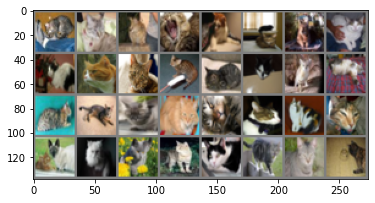

GroundTruth:    cat   cat   cat   cat
Predicted:    cat   dog   dog   cat


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
_, labels = torch.max(labels, 1)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

output = net(images, params, activations)
_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

**Evaluation**: Now testing with your trained model!

In [17]:
correct = 0
total = 0

# since you're not training, you don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        _, labels = torch.max(labels, 1)
        
        # calculate outputs by running images through the network
        output = net(images, params, activations)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 2000 test images: 60 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        _, labels = torch.max(labels, 1)
        output = net(images, params, activations)
        _, predictions = torch.max(output, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class cat   is: 72.7 %
Accuracy for class dog   is: 48.4 %


# Part II

---

## 7. Build your convolutional neural network.

So far, you have tried feed-forward network on image classification, but the performance is not satisfying. Why? 
The reason is that vectorizing the images will lose some critical patterns of images, such as edges, corners, and local structures. Instead, convolutional neural network is very good at capturing these patterns. 

To explore this, let's build a CNN to see how good it is in image classification!

---

**Question 11 (8 points):** Build your CNN: You will build a two-layer CNN with a maxpooling layer in between.
Note that one Fully-Connected (FC) layer will follow the CNN network to map image features into class features. Overall, this network is similar to the one you built above, with the first two feed-forward layers being replaced by the convolutional layers:

            image -> [CNN layer 1] -> [CNN layer 2] -> vectorization -> [FC layer] -> prediction

**Architecture Requirement**:

1. CNN Layer1: suggests that **3 or 5** as your convolution kernel size; the number of output channels can be selected from **[16, 32, 64]**; use ReLU as your activation function
2. CNN Layer2: suggests that **3 or 5** as your convolution kernel size; the number of output channels can be selected from **[128, 256]**; use ReLU as your activation function
3. FC layer: set your parameters, so the input is projected from $\mathbb{R}^{B \times N}$ to $\mathbb{R}^{B \times 2}$, $N$ is defined by your CNN layers' parameters; use sigmoid function as your activation function

Details and hints:
- This time you don't need to write the whole network module. Instead, we provide `nn.Module` as a network wrapper (a base class for all neural network modules in `PyTorch` library). The parameters you defined in this module supports auto gradient computation. 
- For the convolutional layers, you can call `nn.Conv2d`. A convolutional layer usually contains a convolution, an activation and a pooling layer. You can refer to this [useful link](https://pytorch.org/docs/stable/nn.html) to find the layer you want to use.
- Choose appropriate activation functions for all layers.
- As you need to define the input/output dimension for an FC layer, this [tutorial](https://cs231n.github.io/convolutional-networks/) will help you understand how to calculate this.

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define your layers here!! 
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2)
                                    )
        self.layer2 = nn.Sequential(nn.Conv2d(64, 256, 3),
                                    torch.nn.ReLU(),
                                    torch.nn.MaxPool2d(2)
                                    )
        self.layer3 = nn.Sequential(nn.Linear(256 * 6 * 6, 2),
                                    nn.Sigmoid())
        
    def forward(self, x):
        # Your forward pass with the defined layers
        output = self.layer1(x)
        output = self.layer2(output)
        output = output.reshape(output.size(0), -1)
        output = self.layer3(output)
        return output

**Question 12 (4 points):** Here you don't need to write in the details of updating network parameters, we provide `optim.SGD` to help you do this. However, you still need to finish the backpropagation procedure in the main training loop. 

Hint: the `optimizer` implement functions `step()` to update the parameters and `zero_grad()` to reset the gradients.

 

In [20]:
# define the initial learning rate here
learning_rate = 1e-2
n_epochs = 30 # how many epochs to run
# define loss function
criterion = nn.BCELoss()
cnn_net = Net()
cnn_net = cnn_net.cuda()
optimizer = torch.optim.SGD(cnn_net.parameters(), lr=learning_rate)

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Forward 
        output = cnn_net(inputs)
        
        # Compute the loss using the final output
        loss = criterion(output, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[Epoch %d, Step %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Step   200] loss: 0.682
[Epoch 2, Step   200] loss: 0.658
[Epoch 3, Step   200] loss: 0.648
[Epoch 4, Step   200] loss: 0.637
[Epoch 5, Step   200] loss: 0.632
[Epoch 6, Step   200] loss: 0.622
[Epoch 7, Step   200] loss: 0.621
[Epoch 8, Step   200] loss: 0.615
[Epoch 9, Step   200] loss: 0.603
[Epoch 10, Step   200] loss: 0.595
[Epoch 11, Step   200] loss: 0.590
[Epoch 12, Step   200] loss: 0.582
[Epoch 13, Step   200] loss: 0.579
[Epoch 14, Step   200] loss: 0.570
[Epoch 15, Step   200] loss: 0.562
[Epoch 16, Step   200] loss: 0.558
[Epoch 17, Step   200] loss: 0.551
[Epoch 18, Step   200] loss: 0.545
[Epoch 19, Step   200] loss: 0.545
[Epoch 20, Step   200] loss: 0.532
[Epoch 21, Step   200] loss: 0.533
[Epoch 22, Step   200] loss: 0.526
[Epoch 23, Step   200] loss: 0.523
[Epoch 24, Step   200] loss: 0.518
[Epoch 25, Step   200] loss: 0.511
[Epoch 26, Step   200] loss: 0.515
[Epoch 27, Step   200] loss: 0.507
[Epoch 28, Step   200] loss: 0.506
[Epoch 29, Step   200] loss: 

In [21]:
correct = 0
total = 0

# since you're not training, you don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda() 
        _, labels = torch.max(labels, 1)
        
        # calculate outputs by running images through the network
        output = cnn_net(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 2000 test images: 74 %


In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda() 
        _, labels = torch.max(labels, 1)
        output = cnn_net(images)
        _, predictions = torch.max(output, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class cat   is: 79.0 %
Accuracy for class dog   is: 69.0 %


# Submission
1. At the menubar, click `Kernel` → `Restart & Run All`
2. Pack the completed notebook and other project materials into a zip file and upload it via blackboard. The zip file should be named as "[NetID]_proj1.zip"

1% deduction of late assignment total score per hour passing the deadline.

We allow multiple submission attempts but only the latest submission will be considered.